In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics import Accuracy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.2980, 0.2962, 0.2987), (0.2886, 0.2875, 0.2889))
    ]
)

train_dataset = torchvision.datasets.ImageFolder("dataset/train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder("dataset/val", transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=16)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [3]:
import torchvision.models as models

model = models.resnet50()
model.fc = torch.nn.Linear(model.fc.weight.shape[1], 10)
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
epochs = 25

In [4]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()

    perturbations = epsilon * images.grad.sign()
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    original_images = images.clone().detach()

    for _ in range(num_iter):
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        with torch.no_grad():
            perturbations = alpha * images.grad.sign()
            images = images + perturbations
            perturbations = torch.clamp(images - original_images, -epsilon, epsilon)
            images = torch.clamp(original_images + perturbations, 0, 1)

    return images

In [5]:
def train_one_epoch(epoch_index, epsilon=0.03, alpha=0.01, num_iter=7):
    running_loss = []
    last_loss = 0.

    model.train()
    for data in train_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        adv_fgsm = fgsm_attack(model, inputs, labels, epsilon)
        adv_pgd = pgd_attack(model, inputs, labels, epsilon, alpha, num_iter)

        mixed_inputs = torch.cat([inputs, adv_fgsm, adv_pgd], dim=0)
        mixed_labels = torch.cat([labels, labels, labels], dim=0)

        outputs = model(mixed_inputs)
        loss = loss_fn(outputs, mixed_labels)

        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        last_loss = running_loss[-1]


    test_loss = 0.


    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            accuracy.update(preds, labels)

    print(f"[Epoch {epoch_index}] Test loss: {test_loss} Test accuracy: {accuracy.compute()}")
    accuracy.reset()

    return running_loss


In [ ]:
for i in range(epochs):
    losses = []
    losses.extend(train_one_epoch(i))
    torch.save(model.state_dict(), f"model_{i}.pth")

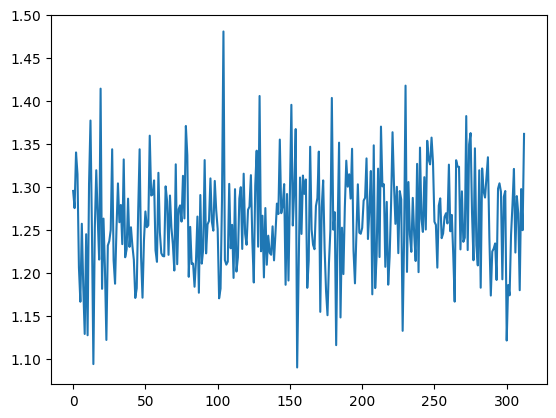

In [ ]:
plt.plot(losses)
plt.show()